# Overview
In a perfect world with perfect data, data scientists would spend all their time doing science with data. In reality, much of our time is spent *preparing* data so that we can eventually do the science part. These preparation, or cleaning steps, are necessary because datasets frequently contain messy or missing data. This lecture will cover some common practices for data preparation and cleaning. This will include:
- Brief review of statistics
- Visual tools for data cleaning: histograms, time series, scatter plots, clustering
- Type consistency and casting
- NaN handling: null labels, dropping vs imputing, imputation methods
- Noise reduction: moving average, median filtering (1D, 2D)

# Stats Review
In data science we often want to determine the probability that a certain data point (or group of data points) in a dataset are real (i.e., to be trusted), vs noise (not to be trusted). Noisy data can have many sources. For example, bad sensors, bad data entry, wrong units, and general upstream bugs in data processing can all negatively impact data quality, and it is often our job to identify *when* that is the case. Statistics can help answer the question: how likely (or unlikely) is it to observe a particular outcome?

## Mean, Median, Standard Deviation

The mean of a vector $x$ of length $n$ is defined as
$$ \overline{x} = \frac{1}{n} \sum_{i = 1}^n x_i $$
The mean is a *measure of central tendency*, meaning that it gives us an estimate of a typical value of a dataset. 

In [5]:
import numpy as np
x = np.array([1, 2, 3, 4, 5, 100, 200])
x_bar = np.mean(x)
print(x_bar)

45.0


Another common measure of central tendency is the median, which gives us the 50th percentile value of a vector. You'll notice that the median is not as influenced by outliers as the mean is:

In [6]:
x_med = np.median(x)
print(x_med)

4.0


While the mean and median provide typical values of a variable, the standard deviation tells us how much variability there is in the variable. In other words, how *far away from the mean* are typical values of the variable? Standard deviation is defined as
$$ \sigma = \sqrt{\frac{\sum_{i = 1}^n (x_i - \overline{x})^2}{n}}$$
Though you will sometimes see $n-1$ instead of $n$ in the denominator. For a large enough sample size, this barely makes a difference.  For what it's worth, `numpy` uses $n$:

In [7]:
x_std = np.std(x)
print(x_std)

71.59409393039545


## Probability density functions
A function $f(x)$ is considered a probability density function if:
- $f(x) \geq 0$ over the function's support
- $\int_{-\infty}^{\infty} f(x)\text{d}x = 1$
- $\int_{a}^{b} f(x) \text{d}x = P(a \leq x \leq b)$

That final bullet point is the most important, and says: the probability that $x$ is between $a$ and $b$ is given by the integral of the probability density function between $a$ and $b$.

The takeaway is that if we know the probability density function for a certain event or process, we are in good shape because we can calculate probabilities based on it via integration. 

## Probability distributions
In general, we won't know the probability density function for whatever we are interested in. But there are certain general *probability distributions* that statisticians have found are widely applicable to a range of problems. We'll talk about a couple of the most common ones.

### Normal Distribution
The normal (or Gaussian) distribution is described by
$$ f(x) = \frac{1}{\sqrt{2\pi} \sigma} \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2}\right) $$
where $\mu$ is the mean of the distribution and $\sigma$ is the standard deviation. We can plot this in python:

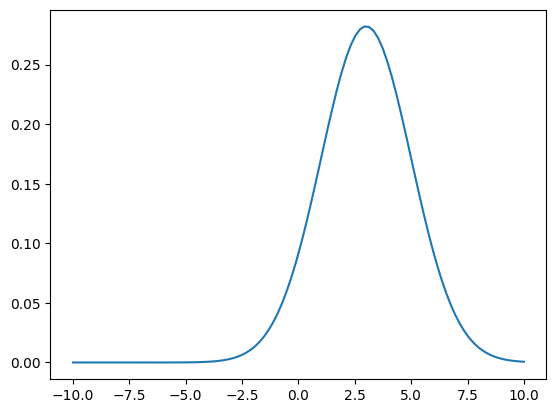

In [8]:
import matplotlib.pyplot as plt
x = np.linspace(-10, 10, 100)
mu = 3
sigma = 2
density = np.exp(-(x - mu)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma)

plt.plot(x, density)

### Quick breakout: try changing the mean and standard deviation of the distribution, $\mu$ and $\sigma$. How does this affect the distribution? 

What the plots of the normal distribution tell us is that values around the mean ($\mu = 3$) are the most common, because there is more area under the curve around that value. Compare that to $x = -10$, there is effectively zero area under the curve, so if a variable in our dataset was described by this distribution and we saw a value of $-10$, that would be highly suspect. However, if we increased the standard deviation significantly, then the density would spread out, and values far from the mean would become increasingly likely. 

There are some simple rules of thumb that you should memorize for a normal distribution:
- 68% of the area under the curve is within 1 standard deviation of the mean
- 95% of the area under the curve is within 2 standard deviations of the mean
- 99.7% of the area under the curve is within 3 standard deviations of the mean

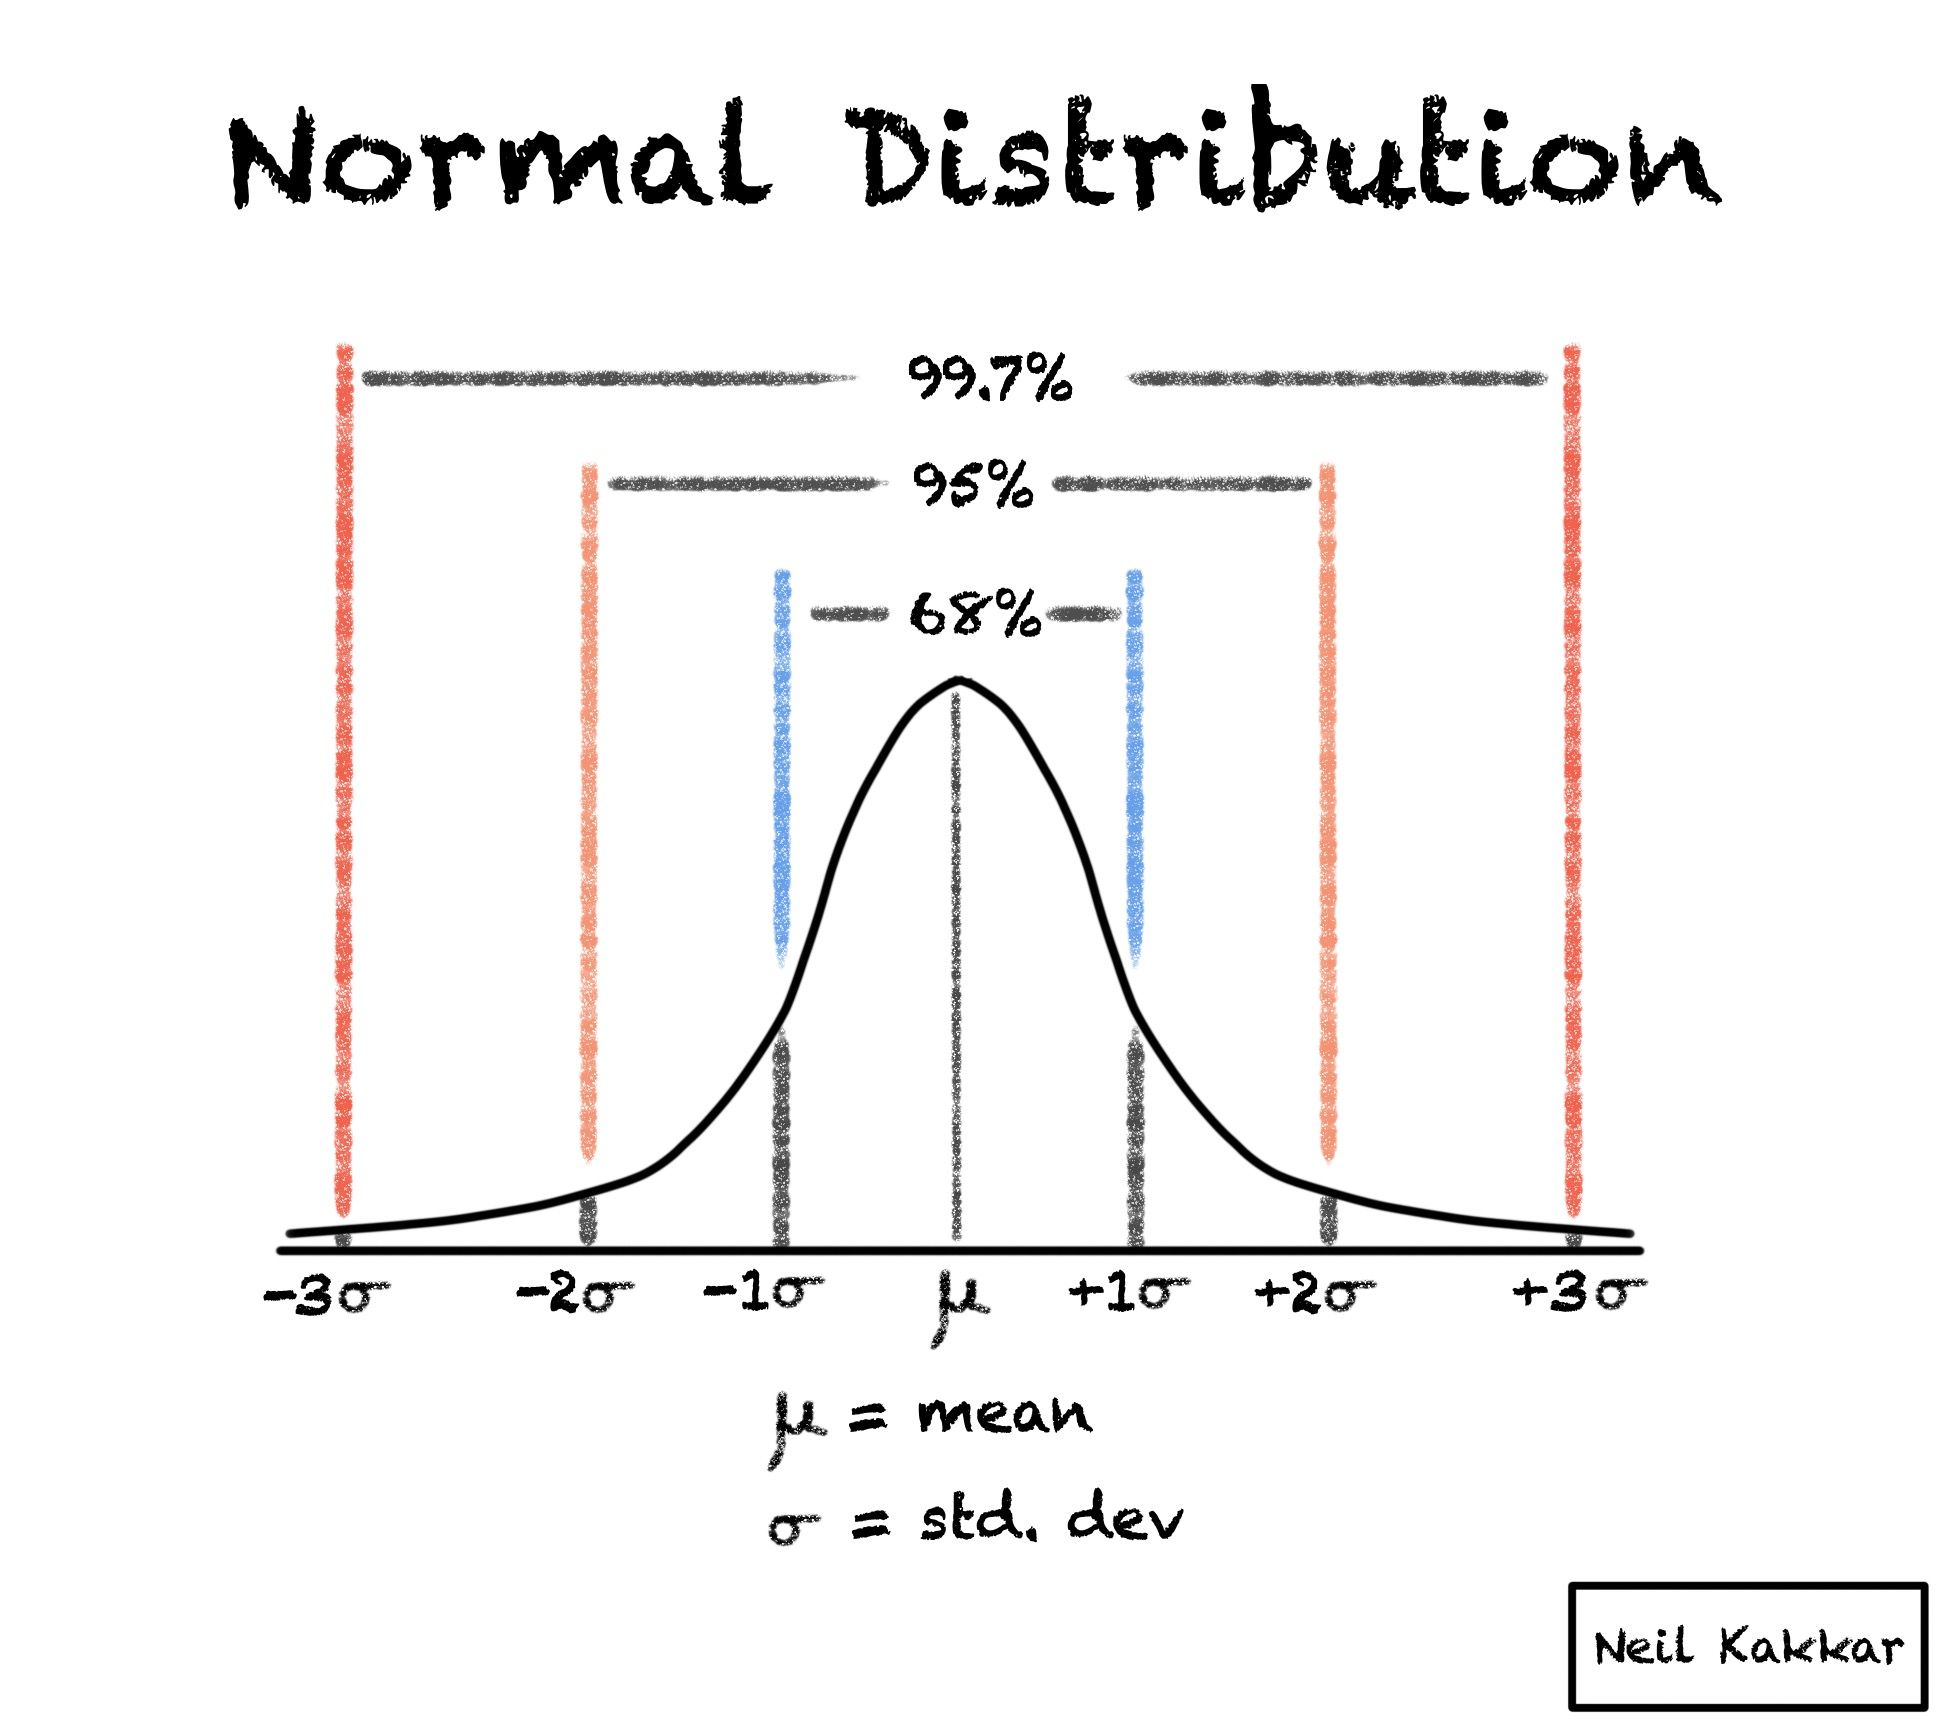

In [9]:
from PIL import Image
Image.open("normal_dist_rule.jpg")

How do we know if a normal distribution is appropriate to use for our data? Usually, we just make a histogram and see how normal it looks. Let's look at a long-term oceanographic dataset from the north pacific to see what the distributions look like for different variables

In [10]:
import pandas as pd
df = pd.read_csv("https://github.com/galenegan/DATA-3320/raw/main/climate/north_pacific.csv")
df = df.rename(columns={"sst": "sea_surface_temperature", "u10": "wind_speed", "hsig": "wave_height"})

array([[<Axes: title={'center': 'sea_surface_temperature'}>,
        <Axes: title={'center': 'wind_speed'}>],
       [<Axes: title={'center': 'wave_height'}>, <Axes: >]], dtype=object)

<Figure size 640x480 with 0 Axes>

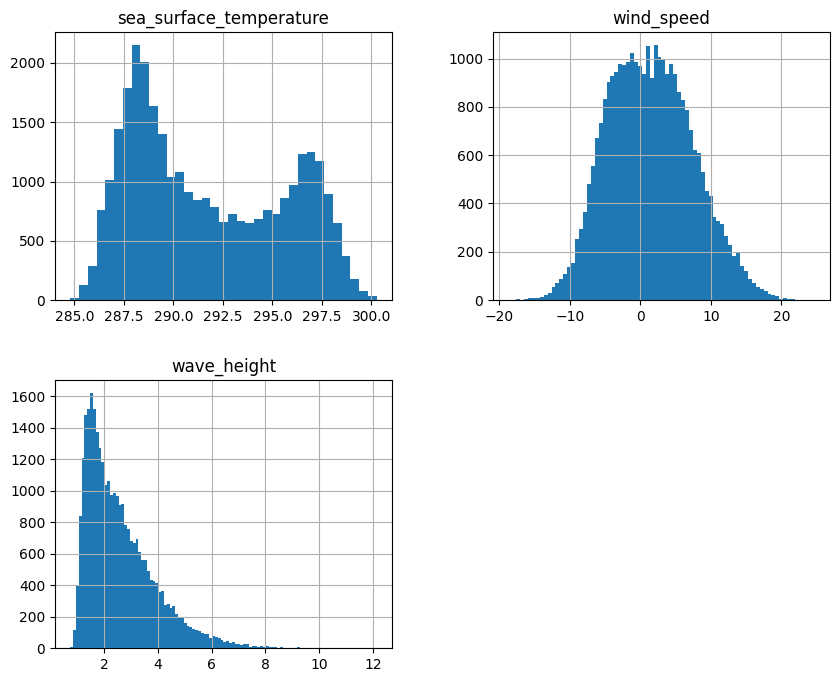

In [11]:
fig = plt.figure()
df.hist(column=["sea_surface_temperature", "wind_speed", "wave_height"], bins="auto", figsize=(10,8))

How would we categorize each of the variables?
- Sea surface temperature: bimodal (why?). Subsets may be normal
- Wind speed: pretty normal, slightly skewed
- wave height: not normal, right-skewed, seems to be clamped at zero

### Log-normal distribution
Log-normal distributions arise in lots of physical scenarios where a variable is restricted to positive values. If a variable is log-normally distributed, that means that the natural log of the variable is normally-distributed. Let's look at wave height to see whether it might be log-normally distributed

(array([   3.,    4.,    3.,   22.,   50.,   83.,  164.,  243.,  349.,
         453.,  600.,  670.,  807.,  909.,  902., 1058., 1044., 1080.,
        1034., 1036.,  981., 1005.,  905.,  969.,  968.,  974., 1016.,
        1009., 1056.,  918.,  924.,  909.,  922.,  833.,  843.,  763.,
         694.,  632.,  590.,  501.,  495.,  404.,  349.,  279.,  270.,
         222.,  193.,  151.,  113.,   93.,   77.,   41.,   41.,   26.,
          15.,   13.,    8.,    9.,    5.,    3.,    5.,    3.]),
 array([-0.29186347, -0.24688758, -0.20191168, -0.15693579, -0.11195989,
        -0.066984  , -0.02200811,  0.02296779,  0.06794368,  0.11291957,
         0.15789547,  0.20287136,  0.24784725,  0.29282315,  0.33779904,
         0.38277494,  0.42775083,  0.47272672,  0.51770262,  0.56267851,
         0.6076544 ,  0.6526303 ,  0.69760619,  0.74258209,  0.78755798,
         0.83253387,  0.87750977,  0.92248566,  0.96746155,  1.01243745,
         1.05741334,  1.10238923,  1.14736513,  1.19234102,  1.2373169

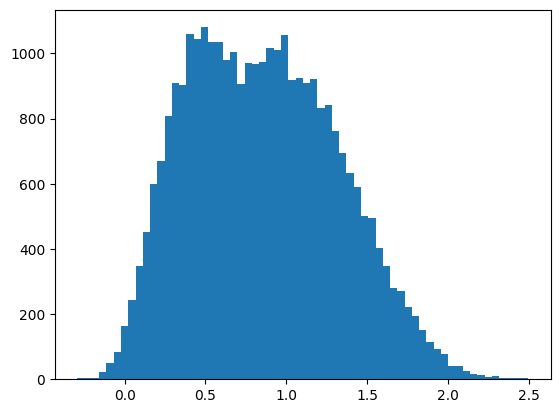

In [12]:
df["log_wave_height"] = np.log(df["wave_height"])
fig = plt.figure()
plt.hist(df["log_wave_height"], bins="auto")

Still a little skewed, but much better! Now we can more easily apply our normal distribution rules of thumb to any given value of wave height, as long as we log-transform it first. For example, we might want to do some analysis that is valid for 95% most common wave conditions. We could filter our dataframe using the 95% rule:

In [16]:
lower_bound = df["log_wave_height"].mean() - 2 * df["log_wave_height"].std()
upper_bound = df["log_wave_height"].mean() + 2 * df["log_wave_height"].std()
condition = ((df["log_wave_height"] >= lower_bound) & (df["log_wave_height"] <= upper_bound))
df_filt = df.loc[condition]

(array([  89.,  158.,  237.,  336.,  446.,  562.,  661.,  775.,  859.,
         879., 1025., 1026., 1045.,  997., 1002., 1001.,  958.,  931.,
         891.,  993.,  903.,  984.,  980., 1010.,  976.,  905.,  874.,
         874.,  889.,  814.,  811.,  682.,  704.,  609.,  541.,  497.,
         470.,  396.,  320.,  275.,  257.,  220.]),
 array([-0.06399904, -0.02015778,  0.02368348,  0.06752474,  0.111366  ,
         0.15520726,  0.19904853,  0.24288979,  0.28673105,  0.33057231,
         0.37441357,  0.41825483,  0.46209609,  0.50593735,  0.54977861,
         0.59361987,  0.63746114,  0.6813024 ,  0.72514366,  0.76898492,
         0.81282618,  0.85666744,  0.9005087 ,  0.94434996,  0.98819122,
         1.03203248,  1.07587374,  1.11971501,  1.16355627,  1.20739753,
         1.25123879,  1.29508005,  1.33892131,  1.38276257,  1.42660383,
         1.47044509,  1.51428635,  1.55812761,  1.60196888,  1.64581014,
         1.6896514 ,  1.73349266,  1.77733392]),
 <BarContainer object of 42 art

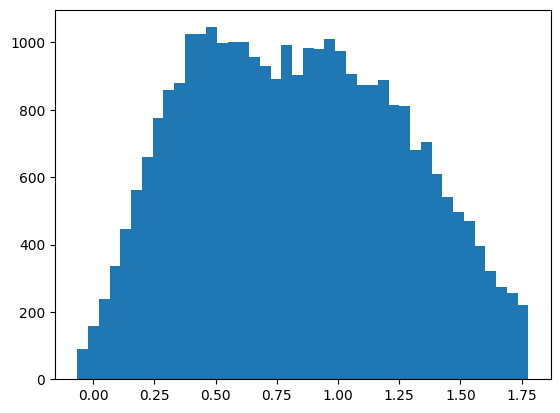

In [17]:
plt.hist(df_filt["log_wave_height"], bins="auto")

# Visual tools for outlier detection

Let's say someone hands you a dataset and tells you to clean it up by getting rid of suspicious outlier values. We'll use a subset of the [UCI Wine Dataset](https://archive.ics.uci.edu/dataset/109/wine) as an example. Contained in the data are the alcohol and proline contents of 2 different types of wine. However, data from a third and pretty different type snuck in as well, and we want to identify which data points are from that third variety. 

In [21]:
df_full = pd.read_csv("wine.csv")
df = df_full.drop(columns=["outlier"])

The best way to start is with a pairplot:

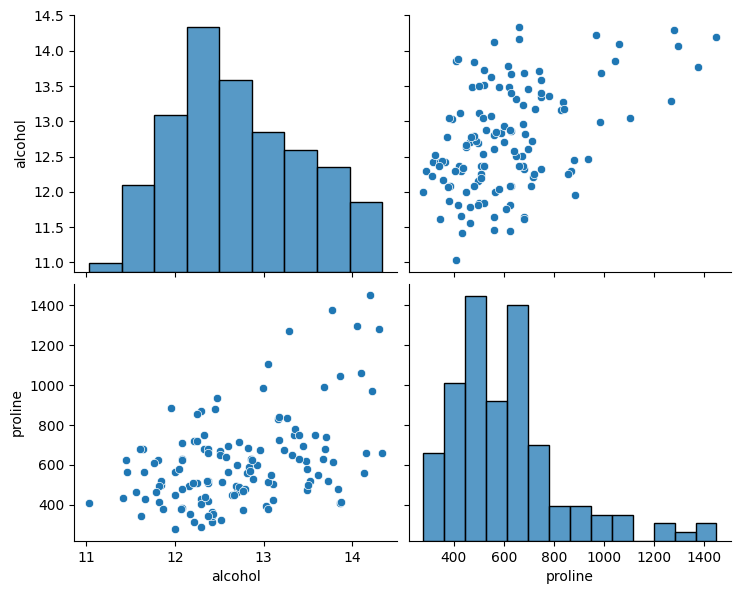

In [31]:
import seaborn as sns
fig = sns.pairplot(df, height=3, aspect=1.25)

Do any clumps of data points look like they might not fit in with the rest? 

Let's check by highlighting the outlier values from the full dataframe:

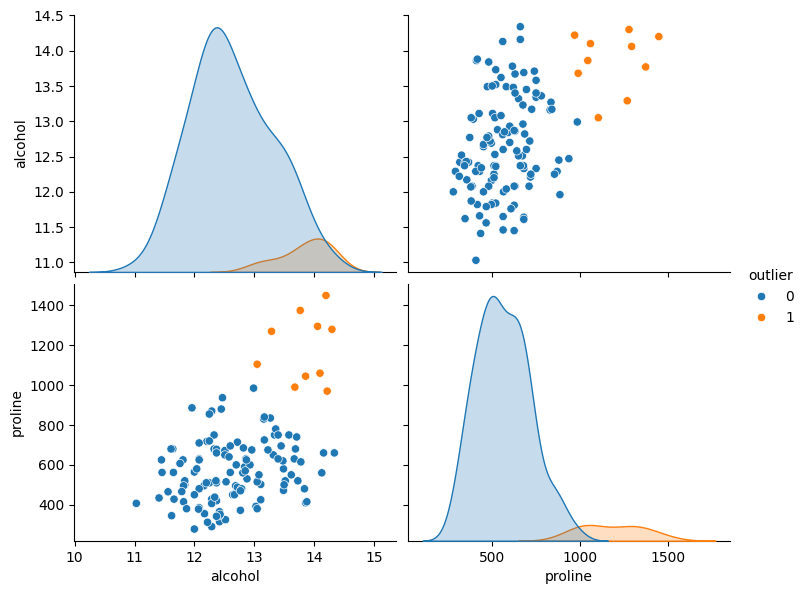

In [32]:
fig = sns.pairplot(df_full, hue="outlier", height=3, aspect=1.25)

So it was indeed the high alcohol + high proline wines that didn't belong. Let's see if we could have done a similar outlier identification by normalizing the proline data and excluding values outside a certain number of standard deviations from the mean:

(array([ 4.,  8., 15., 19., 22., 28., 14.,  7.,  6.,  1.,  5.]),
 array([5.62762111, 5.77777545, 5.92792979, 6.07808413, 6.22823847,
        6.37839281, 6.52854714, 6.67870148, 6.82885582, 6.97901016,
        7.1291645 , 7.27931884]),
 <BarContainer object of 11 artists>)

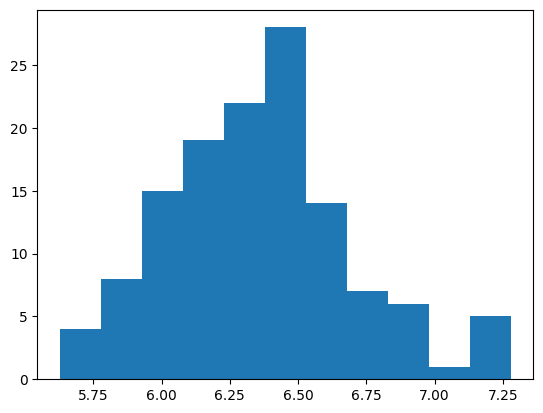

In [40]:
df["log_proline"] = np.log(df["proline"])
plt.hist(df["log_proline"], bins="auto")

In [54]:
n_std_cutoff = 1.5
upper_bound = df["log_proline"].mean() + n_std_cutoff * df["log_proline"].std()

In [51]:
upper_bound

6.863112158825157

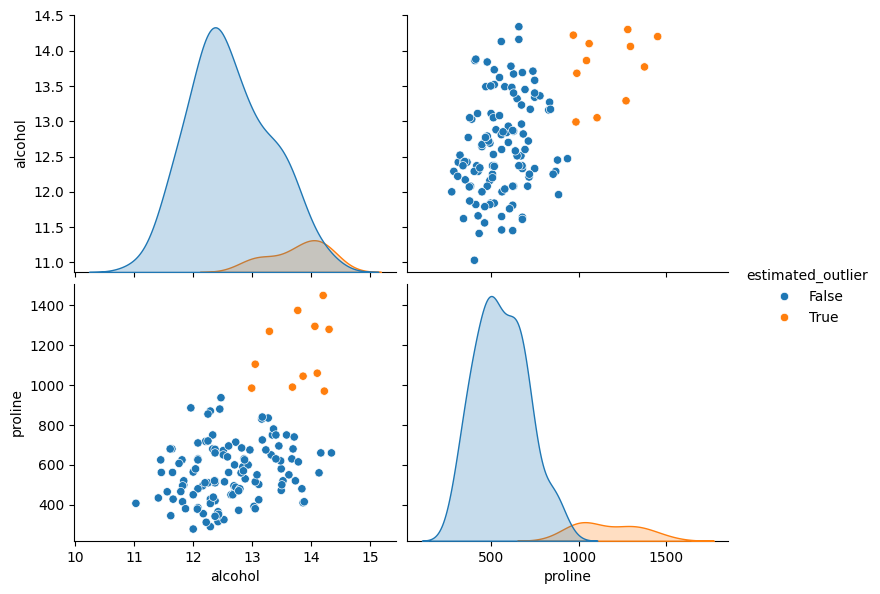

In [55]:
df["estimated_outlier"] = (df["log_proline"] >= upper_bound)
fig = sns.pairplot(df, vars=["alcohol", "proline"], hue="estimated_outlier", height=3, aspect=1.25)

## Breakout: Outlier identification
Load the seismic dataset contained in `seismic.arff`. About 93% of the dataset contains seismic readings that were not correlated to an eventual earthquake (`class = 0`). But the remaining rows contain data that did result in an earthquake (`class = 1`). Using visual outlier detection tools, can you isolate the rows associated with `class = 1` based on the other measured features?

# Type consistency and casting
One of the most common problems you'll find with a dataset is data stored as the wrong type, e.g., strings instead of floats, floats instead of ints, etc. Before analyzing data quantitatively, it is important to make sure that all your types are correct. We'll use a modified version of the wine dataset to highlight some common problems and how to fix them.

In [56]:
df = pd.read_csv("wine_types.csv")

In [58]:
df.head()

,outlier,alcohol,proline
0,1.0,"13,29",concentration = 1270.0
1,1.0,"14,3",concentration = 1280.0
2,1.0,"13,68",concentration = 990.0
3,1.0,"14,06",concentration = 1295.0
4,1.0,"14,22",concentration = 970.0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   outlier  129 non-null    float64
 1   alcohol  129 non-null    object 
 2   proline  129 non-null    object 
dtypes: float64(1), object(2)
memory usage: 3.1+ KB


Each of the columns has at leaset one problem with it. Can you name them?
1. Alcohol:
2. Proline:
3. Outlier:

Let's fix the outlier column first, because it's the easiest:

In [59]:
df["outlier"] = df["outlier"].astype(int)

or...

In [60]:
df["outlier"] = df["outlier"].astype(bool)

In [61]:
df["outlier"]

0       True
1       True
2       True
3       True
4       True
       ...  
124    False
125    False
126    False
127    False
128    False
Name: outlier, Length: 129, dtype: bool

And now alcohol:

In [63]:
df["alcohol"] = df["alcohol"].str.replace(",", ".").astype(float)

In [65]:
df["alcohol"]

0      13.29
1      14.30
2      13.68
3      14.06
4      14.22
       ...  
124    13.71
125    13.40
126    13.27
127    13.17
128    14.13
Name: alcohol, Length: 129, dtype: float64

And proline:

In [66]:
df["proline"] = [float(i.split("= ")[-1]) for i in df["proline"].values]

In [67]:
df["proline"]

0      1270.0
1      1280.0
2       990.0
3      1295.0
4       970.0
        ...  
124     740.0
125     750.0
126     835.0
127     840.0
128     560.0
Name: proline, Length: 129, dtype: float64

# NaN Handling

## Proper labeling

## Imputation

### Interpolation

### Advanced Imputers

# Smoothing Techniques